### Perceptron

In [25]:
%%time
inputs = [1.2, 5.1, 2.1]
weights = [3.1, 2.1, 8.7]
bias = 3

output = sum([inp * weight for inp, weight in zip(inputs, weights)]) + bias
print(output)

35.7
CPU times: user 310 µs, sys: 144 µs, total: 454 µs
Wall time: 394 µs


### Neural Layer

In [29]:
%%time
inputs = [1, 2, 3, 2.5]

weights = [[0.2, 0.8, -0.5, 1.0],
            [0.5, -0.91, 0.26, -0.5],
            [-0.26, -0.27, 0.17, 0.87]]

biases = [2, 3, 0.5]

layer_outputs = []
for neuron_weights, neuron_bias in zip(weights, biases):
    neuron_output = 0
    for n_input, weight in zip(inputs, neuron_weights):
        neuron_output += n_input * weight
    neuron_output += neuron_bias
    layer_outputs.append(neuron_output)

print(layer_outputs)

[4.8, 1.21, 2.385]
CPU times: user 477 µs, sys: 200 µs, total: 677 µs
Wall time: 659 µs


### Neural Layer using numpy functions

In [35]:
%%time
import numpy as np
inputs = [1, 2, 3, 2.5]

weights = [[0.2, 0.8, -0.5, 1.0],
            [0.5, -0.91, 0.26, -0.5],
            [-0.26, -0.27, 0.17, 0.87]]

biases = [2, 3, 0.5]

output = np.dot(weights, inputs) + biases

print(layer_outputs)

[4.8, 1.21, 2.385]
CPU times: user 347 µs, sys: 109 µs, total: 456 µs
Wall time: 417 µs


### Batches, Layers and Objects

In [39]:
%%time

import numpy as np

np.random.seed(0)

X = [[1, 2, 3, 2.5],
        [2.0, 5.0, -1.0, 2.0],
        [-1.5, 2.7, 3.3, -0.8]]

class Layer_Dense():

    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases

layer1 = Layer_Dense(4,5)
layer2 = Layer_Dense(5,2)

layer1.forward(X)
layer2.forward(layer1.output)
print(layer2.output)


[[ 0.148296   -0.08397602]
 [ 0.14100315 -0.01340469]
 [ 0.20124979 -0.07290616]]
CPU times: user 1.6 ms, sys: 4.03 ms, total: 5.63 ms
Wall time: 13.7 ms


### Activation Functions

**Sigmoid Function:**

$f(x) = \frac{1}{1 + e^{-x}}$


<img  src="https://raw.githubusercontent.com/Codecademy/docs/main/media/sigmoid-function.png" width=520>


**REctified Linear Unit (RELU) Function:**

$f(x) = max(0, x)$

<img src="https://i0.wp.com/vitalflux.com/wp-content/uploads/2022/05/Relu-activation-function-neural-network.png?resize=922%2C472&ssl=1" width=520>

**Softmax Function:**

$f(x) = \frac{e^{x_i}}{\sum{e^{x_i}}}$

<img src="https://cdn.botpenguin.com/assets/website/Softmax_Function_07fe934386.png" width=520>

In [19]:
import numpy as np

class Activation():
    def sigmoid(self, x):
        self.output = 1 / (1 + np.exp(-x))

    def relu(self, x):
        self.output = np.maximum(0, x)

    def softmax(self, x):
        norm_x = np.exp(x - np.maximum(x, axis=1, keepdims=True))
        self.output = norm_x / np.sum(norm_x, keepdims=True)
    


In [17]:
activation = Activation()
activation.relu(np.array([1,-2,3]))

array([1, 0, 3])

In [26]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op,uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [98]:
import math
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label 

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only Supports int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad+= other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

Backpropagation

In [75]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'


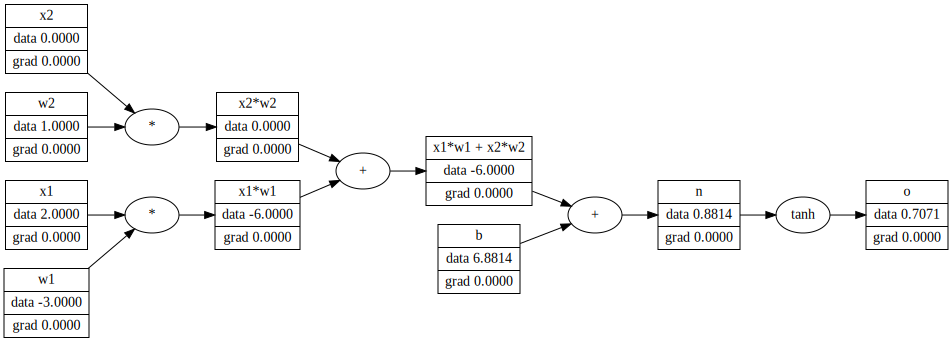

In [76]:
draw_dot(o)

In [77]:
o.backward()

Auto - Backpropagation

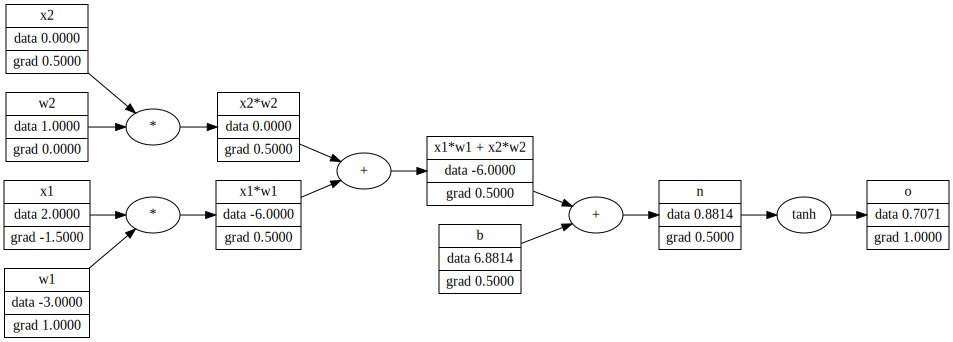

In [78]:
draw_dot(o)

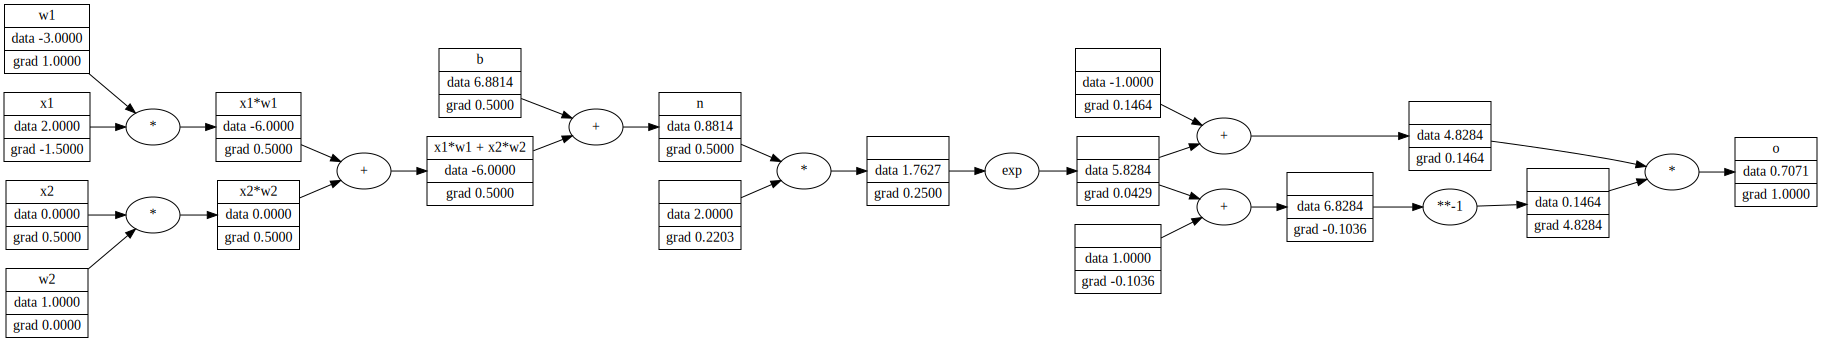

In [99]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp();
o = (e-1) / (e+1)

o.label = 'o'
o.backward()
draw_dot(o)

Using Pytorch

In [107]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('w1', w1.grad.item())

print('x2', x2.grad.item())
print('w2', w2.grad.item())



0.7071066904050358
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [110]:
import random
class Neuron:

    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)),  self.b)
        out = act.tanh()
        return out
    
class Layer:

    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(nouts)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0]
n = Neuron(2)

n(x)


Value(data=-0.22581155539832187)